<a href="https://colab.research.google.com/github/zzcn23/ZoeCannprojects.ipynb/blob/main/ZoeCannU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 7 Project: Polynomials, Splines, and GPs, Oh my!

**Task**:

Two parts:

1. Propose a data set that's compatible with pymc and/or bambi. I must approve your submission before you move on to part 2.

2. Create, analyze, and present any guassian process or approximate GP, degenerate or otherwise (this means glms and b splines are allowed), using pymc within the colab environment, on a data set of your choice, with the following conditions:
  - your final model must have more than 2 predictors. The intercept term doesn't count as a predictor here (even though technically it is), or if must be an actual GP
  - You must document and explain your model selection method. This means you must argue that your model choice (glm, b spline, GP) is better than at least one other choice. You may use either a theoretical or numerical argument.



In [1]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import bambi as bmb
import xarray as xr
import seaborn as sns

In [3]:
#data
vote = pd.read_csv(
    'https://raw.githubusercontent.com/zzcn23/ZoeCannprojecr.ipynb/refs/heads/main/socioeconomic_voting.csv').dropna()

For my data I'm using the same socieconomic voting data I used last unit to see if I can build a better model using b splines to more accurately capture complex (non linear) trends

In [4]:
vote

,State,County Name,FIPS,Unemployment Rate 2020,County Median Household Income (2021),Urban Influence Code 2013,County Income Percentile Within State (2021),Bachelor's Degree or Higher Percentage (2018-2022),Party,Vote Percentage
0,ALABAMA,AUTAUGA,1001,5.3,66444.0,2.0,0.955224,29.6,REPUBLICAN,71.436802
1,ALABAMA,BALDWIN,1003,6.1,65658.0,2.0,0.940299,32.6,REPUBLICAN,76.171373
2,ALABAMA,BARBOUR,1005,7.7,38649.0,6.0,0.164179,11.9,REPUBLICAN,53.451226
3,ALABAMA,BIBB,1007,7.3,48454.0,1.0,0.611940,10.9,REPUBLICAN,78.426264
4,ALABAMA,BLOUNT,1009,4.5,56894.0,1.0,0.895522,14.7,REPUBLICAN,89.571553
...,...,...,...,...,...,...,...,...,...,...
3110,WYOMING,SWEETWATER,56037,7.5,74677.0,8.0,0.826087,20.0,REPUBLICAN,73.236316
3111,WYOMING,TETON,56039,6.0,102709.0,8.0,1.000000,60.3,DEMOCRAT,66.599040
3112,WYOMING,UINTA,56041,6.4,70162.0,8.0,0.739130,19.1,REPUBLICAN,79.247278
3113,WYOMING,WASHAKIE,56043,5.3,62176.0,11.0,0.391304,21.1,REPUBLICAN,80.481151


In [5]:
# Rename columns
vote.rename(columns={"Unemployment Rate 2020": "UR", "County Median Household Income (2021)": "Income", "Urban Influence Code 2013": "Urban","Bachelor's Degree or Higher Percentage (2018-2022)": "Education", "Vote Percentage": "Vote"}, inplace=True)


array([[<Axes: xlabel='FIPS', ylabel='FIPS'>,
        <Axes: xlabel='UR', ylabel='FIPS'>,
        <Axes: xlabel='Income', ylabel='FIPS'>,
        <Axes: xlabel='Urban', ylabel='FIPS'>,
        <Axes: xlabel='County Income Percentile Within State (2021)', ylabel='FIPS'>,
        <Axes: xlabel='Education', ylabel='FIPS'>,
        <Axes: xlabel='Vote', ylabel='FIPS'>],
       [<Axes: xlabel='FIPS', ylabel='UR'>,
        <Axes: xlabel='UR', ylabel='UR'>,
        <Axes: xlabel='Income', ylabel='UR'>,
        <Axes: xlabel='Urban', ylabel='UR'>,
        <Axes: xlabel='County Income Percentile Within State (2021)', ylabel='UR'>,
        <Axes: xlabel='Education', ylabel='UR'>,
        <Axes: xlabel='Vote', ylabel='UR'>],
       [<Axes: xlabel='FIPS', ylabel='Income'>,
        <Axes: xlabel='UR', ylabel='Income'>,
        <Axes: xlabel='Income', ylabel='Income'>,
        <Axes: xlabel='Urban', ylabel='Income'>,
        <Axes: xlabel='County Income Percentile Within State (2021)', ylabel='Incom

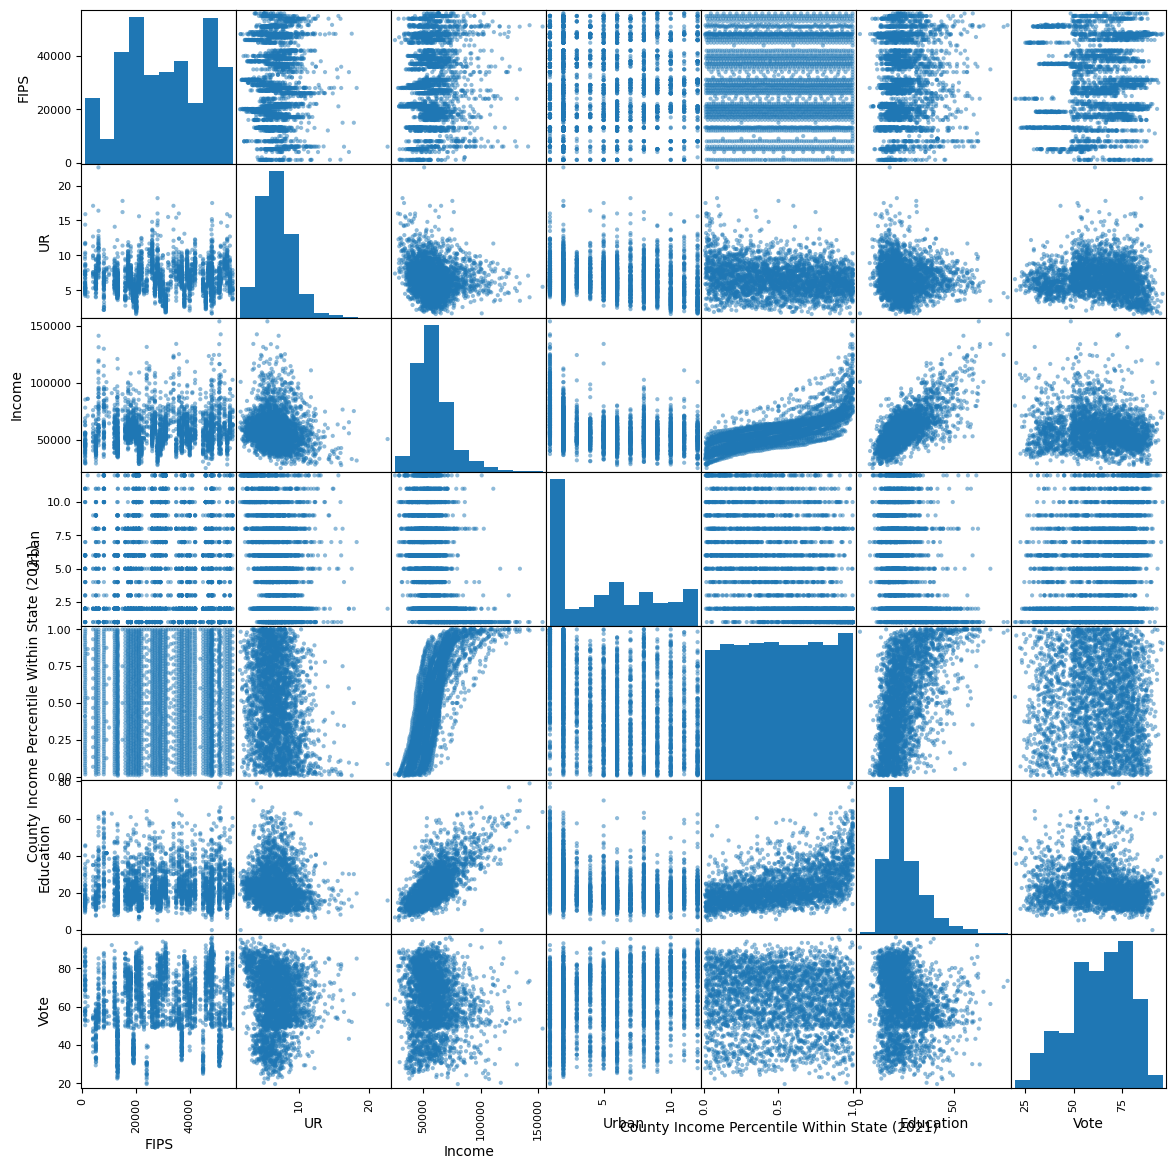

In [ ]:
pd.plotting.scatter_matrix(vote, figsize=(14,14))

Here's my reference model again. I'm using all my variables with no interactions and no b splines.

In [ ]:
#define the model
reference = bmb.Model("`Vote` ~ `Party` + 'Education' + 'Urban' + 'Income'+ 'UR'+ State", data=vote)
#fit the model
reference = reference.fit(idata_kwargs={'log_likelihood': True})

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Now I'm using b splines on the education and voting model

In [9]:
num_knots = 6
knots = np.linspace(0, 80, num_knots+2)[1:-1]
model_spline_t = bmb.Model("Vote ~ bs(Education, degree=2, knots=knots)", vote, family="negativebinomial")
idata_spline_t = model_spline_t.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


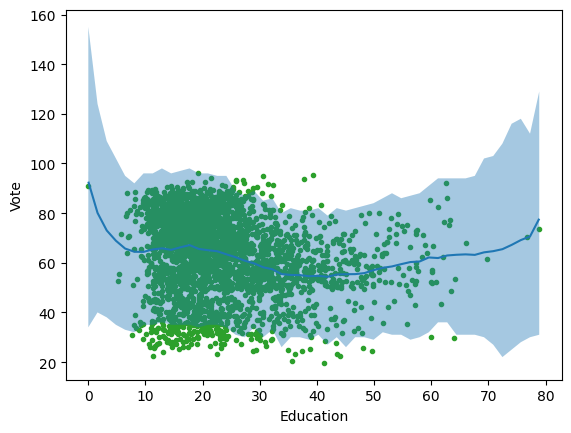

In [ ]:
bmb.interpret.plot_predictions(model_spline_t, idata_spline_t, "Education", pps= True)
plt.plot(vote.Education, vote.Vote, "C2.", zorder=-3)

This looks okay, it's sort of capturing the shape of the data but its unsure of the trend

This is just the education v vote model with no b splines to use as a comparison point

In [12]:
#education v voting
model_Education = bmb.Model("`Vote` ~ 'Education'", data=vote)
#fit the model
idata_Education = model_Education.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Vote', ylabel='Vote'>], dtype=object))

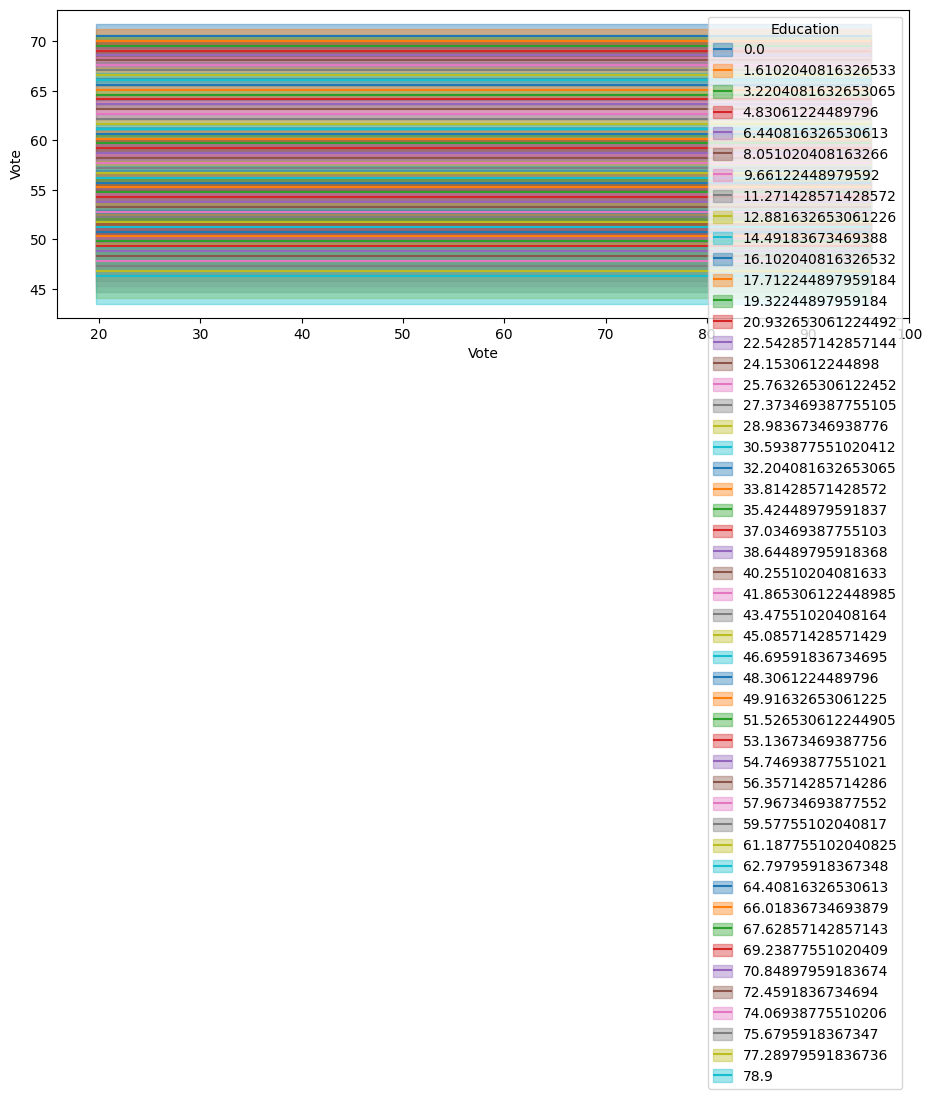

In [13]:
bmb.interpret.plot_predictions(model_Education,
                               idata_Education,
                               ["Vote","Education"],
                               fig_kwargs={"figsize":(11, 4)})

Now I'm doing the same but with income and voting models. I chose income and education as the variables to test individually because on my last project those had the most direct correlation to voting turnout.

In [ ]:
num_knots = 6
knots = np.linspace(25000, 155000, num_knots+2)[1:-1]
model_spline_t2 = bmb.Model("Vote ~ bs(Income, degree=3, knots=knots)", vote, family="negativebinomial")
idata_spline_t2 = model_spline_t.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


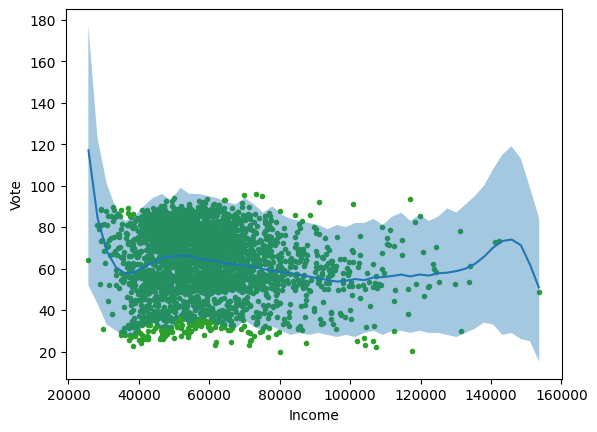

In [ ]:
bmb.interpret.plot_predictions(model_spline_t2, idata_spline_t2, "Income", pps= True)
plt.plot(vote.Income, vote.Vote, "C2.", zorder=-3)

Again, this sort of captures the data trend but its unsure since theres not a clear trend in the data

In [6]:
#income v voting turnout
model_Income = bmb.Model("`Vote` ~ `Income`", data=vote)
#create the model
idata_Income = model_Income.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Vote', ylabel='Vote'>], dtype=object))

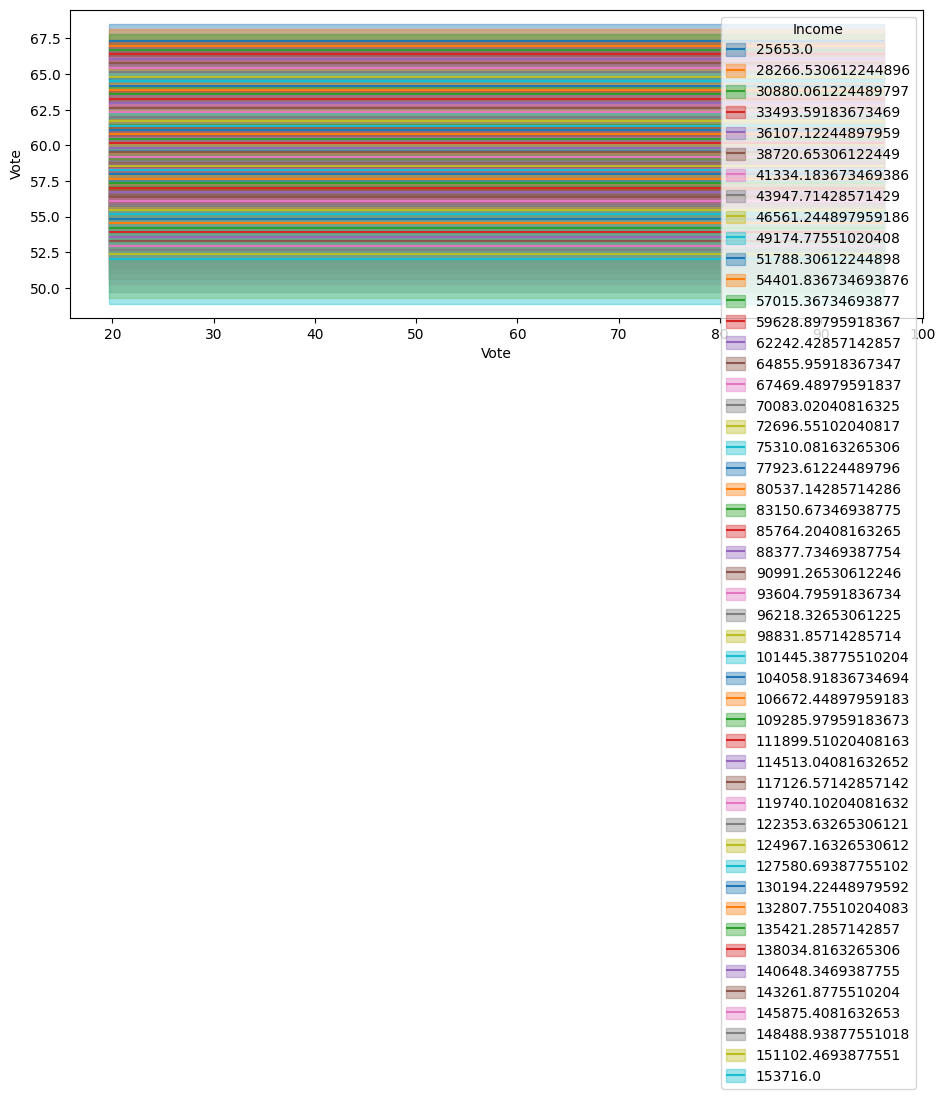

In [14]:
bmb.interpret.plot_predictions(model_Income,
                               idata_Income,
                               ["Vote","Income"],
                               fig_kwargs={"figsize":(11, 4)})

This model is combining education and income with b spines to predict voting turnout

In [10]:
num_knots = 6
knots1 = np.linspace(0, 80, num_knots+2)[1:-1]
knots2 = np.linspace(25000, 150000, num_knots+2)[1:-1]

model_spline_t3 = bmb.Model("Vote ~ bs(Education, degree=3, knots=knots1) + bs(Income, degree=4, knots=knots2))", vote, family="negativebinomial")
idata_spline_t3 = model_spline_t.fit(idata_kwargs={'log_likelihood': True})

Output()

This one is using all the other variables alongside the b splines for education and income. I'm hoping that by using b splines for the continuous variables with the most direct trends (income and education) the model will be able to capture patterns in the data more accurately and predict voting turnout better

In [ ]:
num_knots = 6
knots1 = np.linspace(0, 80, num_knots+2)[1:-1]
knots2 = np.linspace(25000, 150000, num_knots+2)[1:-1]

model_spline_t4 = bmb.Model("Vote ~ bs(Education, degree=3, knots=knots1) + bs(Income, degree=4, knots=knots2)+ Party+ UR+ Urban+ State)", vote, family="negativebinomial")
idata_spline_t4 = model_spline_t.fit(idata_kwargs={'log_likelihood': True})

Output()

Lastly, I'm comparing all these models to see if b splines help make a better model or not

In [ ]:
#cmp_df stands for compare dataframe
cmp_df = az.compare( {"1": reference,"2":idata_spline_t, "3":idata_spline_t2, "4":idata_spline_t3, "5": idata_spline_t4, "6": idata_Education, "7": idata_Income} )

#0 is the best rank; we want a lower elpd_loo
cmp_df

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
1,0,-10988.947801,58.909960,0.000000,0.977240,46.976744,0.000000,True,log
6,1,-12930.552150,2.703103,1941.604349,0.000000,35.642597,54.691103,False,log
7,2,-12971.843423,2.824808,1982.895623,0.013856,33.946242,55.119648,False,log
2,3,-13046.998895,8.327085,2058.051094,0.008905,37.353440,57.574791,True,log
3,4,-13078.767892,10.887148,2089.820091,0.000000,35.384256,56.705212,True,log
5,5,-13078.794197,10.878987,2089.846396,0.000000,35.371236,56.693423,True,log
4,6,-13078.910147,10.971063,2089.962346,0.000000,35.400056,56.708291,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

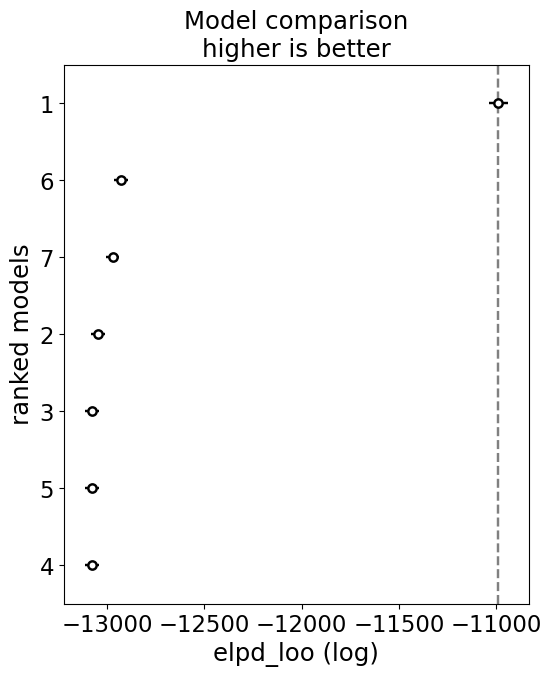

In [ ]:
az.plot_compare(cmp_df)

So unfortunately, the b splines did not result in better models. The reference model was still the best and the single variable models without b splines were better than b spline models. I think this is because the b splines are leading to overfitting and the trends can't be captured by b splines because there's too much noise and interaction between all the predictors. The b splines did have better looking graphs for the single variable models though compared to the original graphs.